In [2]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import cellcharter as cc
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('input_data/classified_csv_complete_binary_global.csv')

markers = ["PD1", "MHCII", "CD206", "CD45", "CD11C", "LY6G", "GRZB", "FOXP3", "CC3", 
           "CD8", "CD11B", "CD3", "LY6B2", "F480", "ASMA", "KI67", "PANCK"]

X = df[markers].values

obs = df[["sample_ID", "short_ID", "ObjectNumber", "class", "Tumor_ID", "Treatment", "slide", 
          "ROI_factor_per_tumor", "tum_factor_per_treatment"]].copy()

# Plug in Global coordinates for spatial information
spatial = df[["global_location_X", "global_location_Y"]].values

adata = ad.AnnData(X=X, obs=obs)

adata.var = pd.DataFrame(index=markers)
adata.var["marker"] = markers

adata.obsm["spatial"] = spatial

/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
print (adata)

AnnData object with n_obs × n_vars = 1695965 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    obsm: 'spatial'


In [4]:
adata.write("anndata/classified_csv_complete_binary_global.h5ad")

In [3]:
# Before analysis, make sure each sample will be scaled indepenendently.
adata = sc.read('anndata/classified_csv_complete_binary_global.h5ad')

In [4]:
sq.gr.spatial_neighbors(adata, library_key="Tumor_ID")

In [5]:
print (adata)

AnnData object with n_obs × n_vars = 1695965 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    var: 'marker'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [6]:
#for consistency, drop the long-distance connectivity 
cc.gr.remove_long_links(adata)

In [13]:
cc.gr.aggregate_neighbors(adata, n_layers=3, sample_key = "Tumor_ID")

100%|███████████████████████████████████████████| 12/12 [00:17<00:00,  1.47s/it]


In [8]:
gmm = cc.tl.Cluster(n_clusters=5, random_state=12345)

In [14]:
gmm.fit(adata, use_rep='X_cellcharter')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=9` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 25: 100%|████████████████████████| 1/1 [00:02<00:00,  0.40it/s, nll=-186.]


In [15]:
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|████████████████████| 1/1 [00:01<00:00,  0.75it/s]


/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/guoz/miniconda3/envs/cellcharter-env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: U

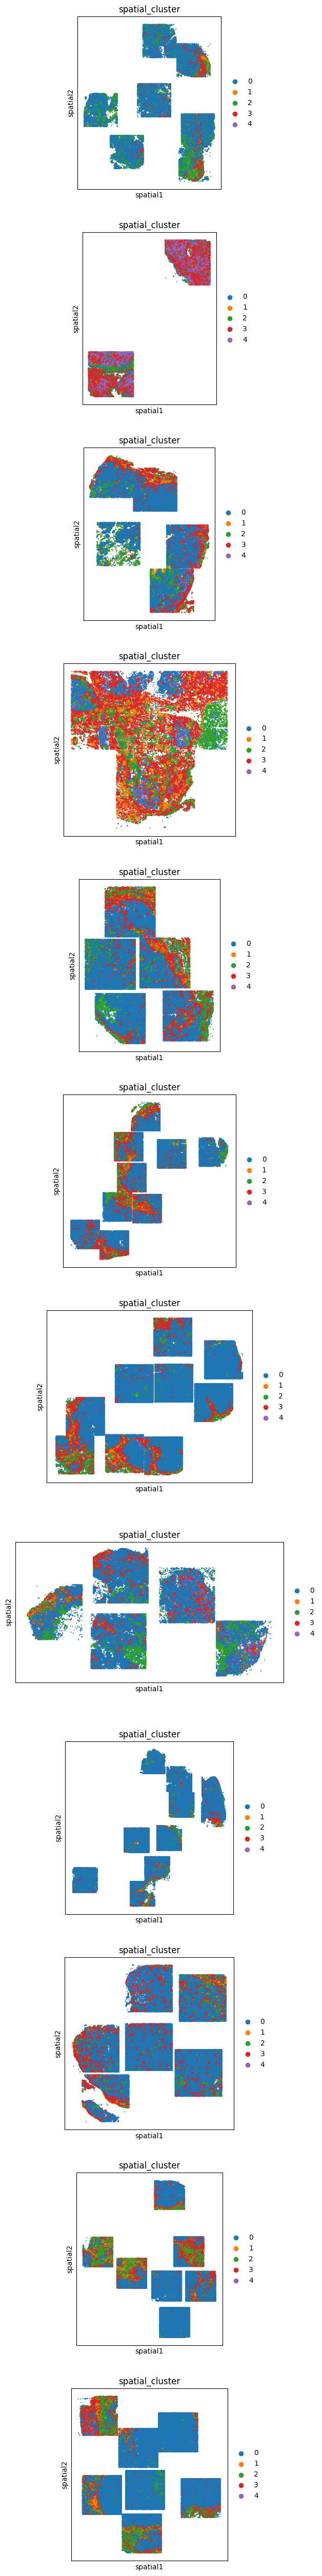

In [16]:
sq.pl.spatial_scatter(adata, 
                      shape=None, 
                      size=0.4, 
                      color="spatial_cluster", 
                      library_key="Tumor_ID",
                      ncols=1)

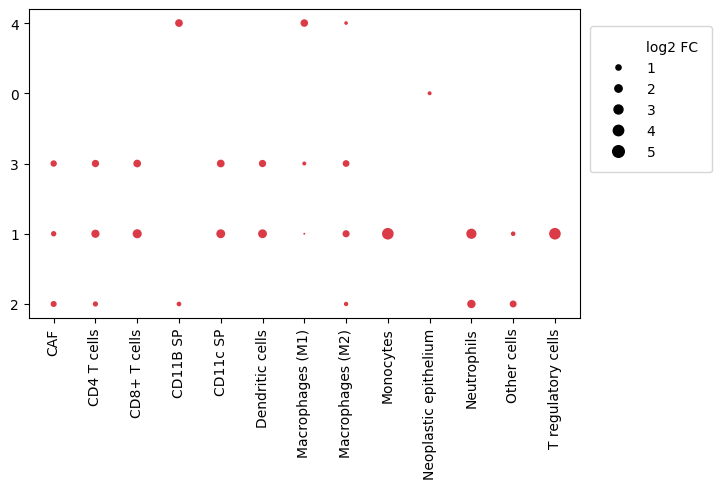

In [17]:
cc.gr.enrichment(adata, group_key='spatial_cluster', label_key='class')
cc.pl.enrichment(adata, group_key='spatial_cluster', label_key='class', figsize=(6,5), fontsize=10, dot_scale=2)

In [18]:
print(adata)

AnnData object with n_obs × n_vars = 1695965 × 17
    obs: 'sample_ID', 'short_ID', 'ObjectNumber', 'class', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment', 'spatial_cluster'
    var: 'marker'
    uns: 'spatial_neighbors', '_cellcharter', 'spatial_cluster_colors', 'spatial_cluster_class_enrichment'
    obsm: 'spatial', 'X_cellcharter'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [22]:
extracted_data = adata.obs[['class', 'short_ID', 'Tumor_ID', 'spatial_cluster','Treatment', 'slide' ]]
print(extracted_data)

                         class                short_ID Tumor_ID  \
0                          CAF   Control_BT00011_ROI_1  BT00011   
1                          CAF   Control_BT00011_ROI_1  BT00011   
2                          CAF   Control_BT00011_ROI_1  BT00011   
3                          CAF   Control_BT00011_ROI_1  BT00011   
4                          CAF   Control_BT00011_ROI_1  BT00011   
...                        ...                     ...      ...   
1695960  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695961  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695962  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695963  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   
1695964  Neoplastic epithelium  Olaparib_BT00023_ROI_7  BT00023   

        spatial_cluster Treatment    slide  
0                     3   Control  KN00012  
1                     0   Control  KN00012  
2                     0   Control  KN00012  
3              

/var/folders/y0/xtkgj_xx1n3fylstssq873p1r3q_9y/T/ipykernel_3084/4100516163.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = extracted_data.groupby(["spatial_cluster", "class"]).size().unstack(fill_value=0)


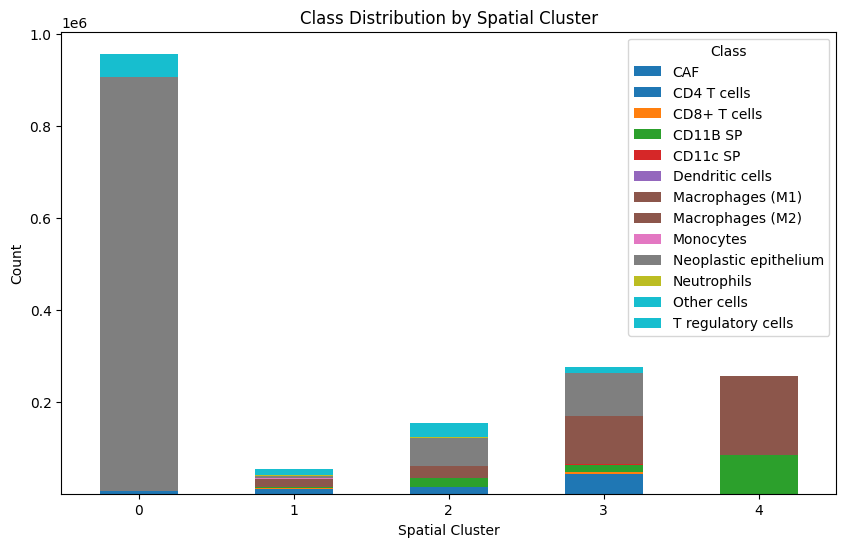

In [20]:
agg_data = extracted_data.groupby(["spatial_cluster", "class"]).size().unstack(fill_value=0)
agg_data.plot(kind="bar", stacked=True, colormap="tab10", figsize=(10,6))
plt.title("Class Distribution by Spatial Cluster")
plt.xlabel("Spatial Cluster")
plt.ylabel("Count")
plt.xticks(rotation=0, ha="center")
plt.legend(title="Class")
plt.show()

In [21]:
extracted_data.to_csv("complete_spatial_cluster_extract.csv", index=False)  # Save as CSV
adata.write("anndata/classified_csv_complete_binary_global_annotated.h5ad") # Save anndata